## Import necessary modules and data

In [1]:
import numpy as np
import pandas as pd
import seaborn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score
from keras_metrics import precision
from sklearn.model_selection import cross_validate
from livelossplot import PlotLossesKeras
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras_metrics import precision
import random



Using TensorFlow backend.


## Wczytujemy poprzednio utworzone zbiory

In [2]:
X = pd.read_csv('../data/cleaned_data.csv', index_col=0)
y = pd.read_csv('../data/labels.csv', header = None)

X_test = pd.read_csv('../data/X_test.csv', index_col=0)
X_train = pd.read_csv('../data/X_train.csv', index_col=0)


y_train = pd.read_csv('../data/y_train.csv', index_col=0)
y_test = pd.read_csv('../data/y_test.csv', index_col=0)

## Wyrzucam również informację odnośnie posiadania karty kredytowej - korelacja ze zmienną objaśnianą wynosiła 0.0003

In [3]:
X_train = X_train.drop(['HasCrCard'], axis=1)
X_test = X_test.drop(['HasCrCard'], axis=1)

In [4]:
scaler = StandardScaler().fit(X_train)

X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

/home/seba/.virtualenvs/rl/lib/python3.5/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/seba/.virtualenvs/rl/lib/python3.5/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/seba/.virtualenvs/rl/lib/python3.5/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.



## Poza standaryzacja i stratyfikacją zbioru treningowego i testowego ustalam również wagi dla danych klas

In [5]:
class_weight = {
                0: 3.,
                1: 1.
               }

es = EarlyStopping(monitor='val_precision', mode='max', verbose=1, patience=3)

## Buduję pierwszy model
W callbacku korzystam z metody PlotLossesKeras(), która umożliwi nam tworzenie interesujących nas wykresów danych metryk w czasie rzeczywistym korzystam również z early stopping zdefiniowanego wyżej, aby nie dopuścić do przetrenowania modelu.

Sprawdźmy jednak najpierw, jak mieni nam się nasza metryka na zbiorze treningowym i walidacyjnym - użyjemy do tego metody PlotLossesKeras, która w sposób graficzny przedstawi nam powyższe metryki.

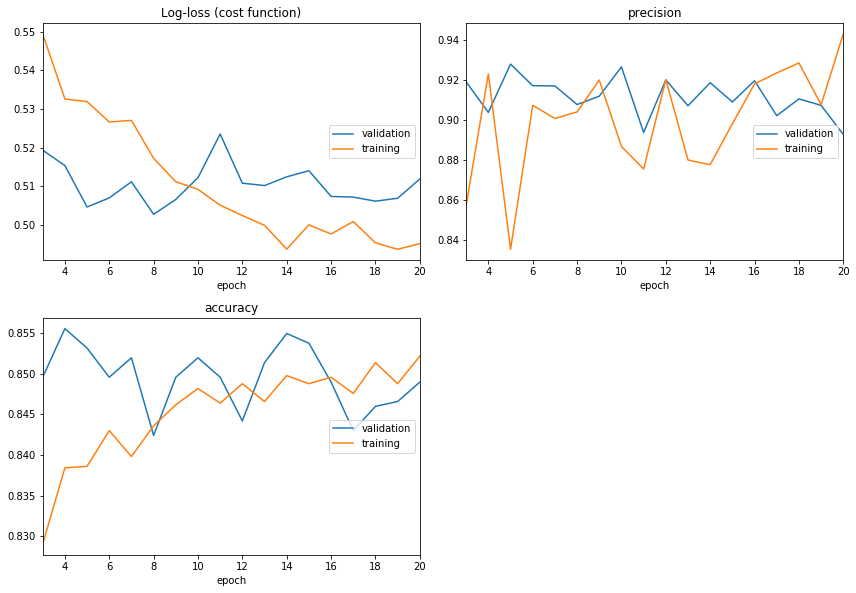

Log-loss (cost function):
validation (min:    0.503, max:    0.574, cur:    0.512)
training   (min:    0.494, max:    0.656, cur:    0.495)

precision:
validation (min:    0.843, max:    0.928, cur:    0.893)
training   (min:    0.363, max:    0.943, cur:    0.943)

accuracy:
validation (min:    0.817, max:    0.856, cur:    0.849)
training   (min:    0.802, max:    0.852, cur:    0.852)


In [6]:
model = Sequential()
model.add(Dense(20, activation='relu', input_shape=(9,)))


model.add(Dropout(0.1,))
model.add(Dense(75, activation='relu'))


model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=[precision(),'accuracy'])
                   
model.fit(X_train_std, y_train, epochs=20, batch_size=2,
           verbose=1, validation_split=0.25, callbacks = [PlotLossesKeras()], class_weight=class_weight)

## Właściwy model z metodą wczesnego stopowania

Widzimy już, jak wyglądają wykresy funkcji straty na zbiorze walidacyjnym i treningowym wraz ze zwiększającymi się epokami. Użyjmy teraz wyżej wymienionej metody, aby nie dopuścić do przetrenowania. |

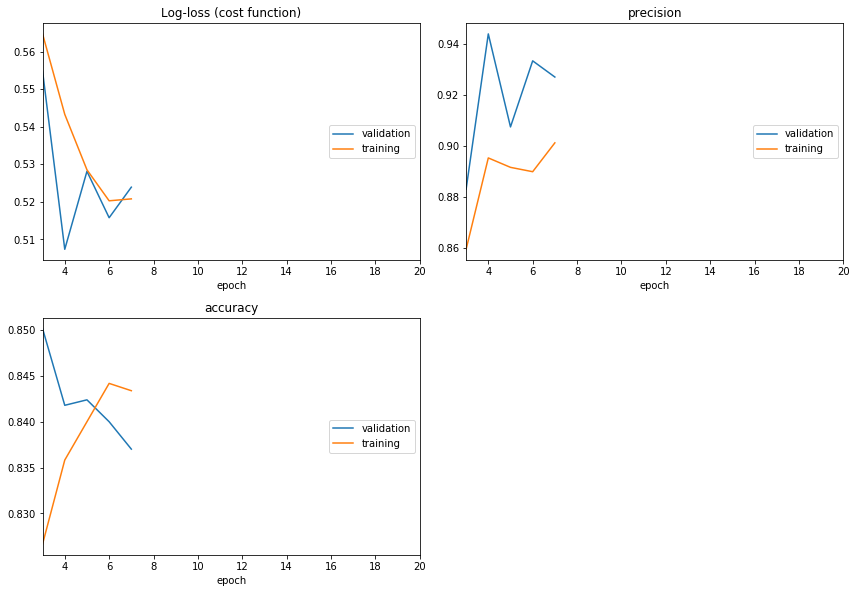

Log-loss (cost function):
validation (min:    0.507, max:    0.606, cur:    0.524)
training   (min:    0.520, max:    0.663, cur:    0.521)

precision:
validation (min:    0.308, max:    0.944, cur:    0.927)
training   (min:    0.350, max:    0.901, cur:    0.901)

accuracy:
validation (min:    0.796, max:    0.850, cur:    0.837)
training   (min:    0.798, max:    0.844, cur:    0.843)
Epoch 00007: early stopping


In [7]:
model_2 = Sequential(name='model_2')
model_2.add(Dense(20, activation='relu', input_shape=(9,)))


model_2.add(Dropout(0.1,))
model_2.add(Dense(75, activation='relu'))


model_2.add(Dense(1, activation='sigmoid'))


model_2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=[precision(),'accuracy'])
                   
model_2.fit(X_train_std, y_train, epochs=20, batch_size=2,
           verbose=1, validation_split=0.25, callbacks = [PlotLossesKeras(), es], class_weight=class_weight)

## Sprawdźmy predykcję i wygenerujmy raport klasyfikacyjny

In [8]:
y_pred = model_2.predict_classes(X_test_std)

report = classification_report(y_test, y_pred, output_dict=False)
print(report)

              precision    recall  f1-score   support

           0       0.83      1.00      0.91      2628
           1       0.92      0.21      0.34       672

   micro avg       0.83      0.83      0.83      3300
   macro avg       0.88      0.60      0.62      3300
weighted avg       0.85      0.83      0.79      3300



## Zapisujemy wytrenowany model

In [9]:
model_2.save("../saved_models/model_2.h5")

### autor: Paweł Bogdan